# 【問題1】全結合層のクラス化
コーディング

全結合層のクラスの雛形を載せました。コンストラクタで重みやバイアスの初期化をして、あとはフォワードとバックワードのメソッドを用意します。

重みW、バイアスB、およびフォワード時の入力Xをインスタンス変数として保持しておくことで、煩雑な入出力は不要になります。

なお、インスタンスも引数として渡すことができます。そのため、初期化方法のインスタンスinitializerをコンストラクタで受け取れば、それにより初期化が行われます。渡すインスタンスを変えれば、初期化方法が変えられます。

また、引数として自身のインスタンスselfを渡すこともできます。これを利用してself = self.optimizer.update(self)という風に層の重みの更新が可能です。更新に必要な値は複数ありますが、全て全結合層が持つインスタンス変数にすることができます。

初期化方法と最適化手法のクラスについては後述します。

In [1]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.initializer = initializer
        self.optimizer = optimizer
        
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = self.initializer.W(n_nodes1, n_nodes2)
        self.B = self.initializer.B(n_nodes1, n_nodes2)
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X: 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """      
        self.forward_X = X.copy()
        A = X @ self.W + self.B
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.dB = dA
        self.dW = self.forward_X.T @ dA 
        dZ = dA @ self.W.T
        
        # 更新
        self = self.optimizer.update(self)
        
        return dZ

# 【問題2】初期化方法のクラス化
前述のように、全結合層のコンストラクタに初期化方法のインスタンスを渡せるようにします。雛形に必要なコードを書き加えていってください。標準偏差の値（sigma）はコンストラクタで受け取るようにすることで、全結合層のクラス内にこの値（sigma）を渡さなくてすむようになります。

これまで扱ってきた初期化方法はSimpleInitializerクラスと名付けることにします。

In [2]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(n_nodes1,n_nodes2)
        return W
    
    def B(self, n_nodes1, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(n_nodes2)
        B = np.zeros(n_nodes2)
        return B

# 【問題3】最適化手法のクラス化
最適化手法に関しても初期化方法同様に全結合層にインスタンスとして渡します。バックワードのときにself = self.optimizer.update(self)のように更新できるようにします。こちらも雛形を用意しましたので、必要なコードを書き加えていってください。

これまで扱ってきた最適化手法はSGDクラス（Stochastic Gradient Descent、確率的勾配降下法）として作成します。

In [3]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        layer.W -= self.lr * layer.dW / layer.dB.shape[0]
        layer.B -= self.lr * np.mean(layer.dB, axis=0)        
        
        return layer

# 【問題4】活性化関数のクラス化
活性化関数もクラス化を行なってください。

上記サンプルコード3ではソフトマックス関数のバックプロパゲーションに交差エントロピー誤差の計算も含む実装を想定しています。

In [48]:
class Softmax:
    def __init__(self):
        self.forward_A = None
    
    def forward(self,a):
        c = np.max(a) #一番大きい値を取得
        exp_a = np.exp(a - c) #各要素から一番大きな値を引く（オーバーフロー対策）
        sum_exp_a = np.sum(exp_a, axis=1) #要素の値　/ 全体の要素の合計
        self.forward_A = exp_a / sum_exp_a.reshape(-1,1)
        return self.forward_A
    
    def backward(self,y): # 正解ラベルと予測値の差を算出
        
        loss_sum = np.sum(y * np.log(self.forward_A), axis=1)
        
        #勾配の計算
        dA = self.forward_A - y
        
        return dA, -np.mean(loss_sum)

In [5]:
class Sigmoid:
    
    def __init__(self):
        
        self.forward_A = None
        
    def forward(self, A):
        
        self.forward_A = 1 / (1 + np.exp(-A)) 
        
        return self.forward_A 
    
    
    def backward(self, dZ):
        dA = dZ * (1 - self.forward_A ) * self.forward_A
        return dA

In [6]:
class Tanh:
    def __init__(self):
        self.forward_A = None
        
    def forward(self,A):
        self.forward_A = np.tanh(A)
        return self.forward_A
    
    def backward(self,dZ):
        dA = dZ * (1-self.forward_A ** 2)
        return dA

# 【問題5】ReLUクラスの作成
現在一般的に使われている活性化関数であるReLU（Rectified Linear Unit）をReLUクラスとして実装します。

ReLUは以下の数式です。

$
% <![CDATA[
f(x) = ReLU(x) = \begin{cases}
x  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases} %]]>
$

x : ある特徴量。スカラー

実装上はnp.maximumを使い配列に対してまとめて計算が可能です。

numpy.maximum — NumPy v1.15 Manual

一方、バックプロパゲーションのための x に関する f(x) の微分は以下のようになります。

$
% <![CDATA[
\frac{\partial f(x)}{\partial x} = \begin{cases}
1  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases} %]]>
$

数学的には微分可能ではないですが、 
x=0のとき 0とすることで対応しています。

フォワード時の x の正負により、勾配を逆伝播するかどうかが決まるということになります。



In [58]:
class ReLU:
    def __init__(self):
        self.forward_A = None
        
    def forward(self, A):
        self.forward_A = A.copy()
        return np.maximum(0,A)
    
    def backward(self, A):
        return np.where(self.forward_A > 0, A, 0)

# 【問題6】重みの初期値
ここまでは重みやバイアスの初期値は単純にガウス分布で、標準偏差をハイパーパラメータとして扱ってきました。しかし、一般的に良い初期値の取り方が知られています。

シグモイド関数やハイパボリックタンジェント関数のときはXavierの初期値（またはGlorotの初期値）、ReLUのときはHeの初期値が使われます。

XavierInitializerクラスと、HeInitializerクラスを作成します。

それぞれの初期化方法における 
σ
 は次の式で求められます。

「Xavierの初期値」

$
\sigma = \frac{1}{\sqrt{n}}
$

n: 前の層のノード数

（論文）

Glorot, X., & Bengio, Y. (n.d.). Understanding the difficulty of training deep feedforward neural networks.

「Heの初期値」

$
\sigma = \sqrt{\frac{2}{n}}
$

n : 前の層のノード数

（論文）

He, K., Zhang, X., Ren, S., & Sun, J. (2015). Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification.


In [8]:
class XavierInitializer:
    """
    初期化
    Parameters
    ----------
    sigma : float  標準偏差
    """
    
    def __init__(self):
        self.sigma = None
        self.n_nodes1 = 0
        self.n_nodes2 = 0
        
    def W(self,n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """

        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2        
        
        W = np.random.randn(self.n_nodes1,self.n_nodes2) / (self.n_nodes1 ** 0.5)
        return W
    
    def B(self,n_nodes1, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        B = np.random.randn(self.n_nodes2) / (self.n_nodes1 ** 0.5)
        B = np.zeros(n_nodes2)
        return B

In [28]:
class HeInitializer:
    """
    初期化
    Parameters
    ----------
    sigma : float  標準偏差
    """
    
    def __init__(self):
        self.sigma = None
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2        
        W = np.random.randn(self.n_nodes1,self.n_nodes2) * ((2 / self.n_nodes1) ** 0.5)
        return W
    
    def B(self, n_nodes1, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.sigma = (2 /  self.n_nodes1) ** 0.5
        B = self.sigma * np.random.randn( self.n_nodes2)
        B = np.zeros(n_nodes2)
        return B

# 【問題7】最適化手法
コーディング

学習率は学習の良し悪しにとって重要なハイパーパラメータであり、これを学習過程で変化させていく方法が現在では一般的です。様々な手法が提案されていますが、今回はその中でも基本的な、AdaGradを実装します。

まず、これまで使ってきたSGDを確認します。


$
W_i^{\prime} = W_i - \alpha E(\frac{\partial L}{\partial W_i}) \\
$  

$
B_i^{\prime} = B_i - \alpha E(\frac{\partial L}{\partial B_i})
$


続いて、AdaGradです。バイアスの数式は省略しますが、重みと同様のことをします。

更新された分だけその重みに対する学習率を徐々に下げていきます。イテレーションごとの勾配の二乗和 Hを保存しておき、その分だけ学習率を小さくします。

学習率は重み一つひとつに対して異なることになります。

$
H_i^{\prime}  = H_i+E(\frac{\partial L}{\partial W_i})×E(\frac{\partial L}{\partial W_i})\\
$  

$
W_i^{\prime} = W_i - \alpha \frac{1}{\sqrt{H_i^{\prime} }} E(\frac{\partial L}{\partial W_i}) \\
$

AdaGradクラスを作成し、上記の数式にもとづいて実装してください。

（論文）

Duchi JDUCHI, J., & Singer, Y. (2011). Adaptive Subgradient Methods for Online Learning and Stochastic Optimization * Elad Hazan. Journal of Machine Learning Research (Vol. 12).


In [10]:
class AdaGrad:
    """
    AdaGrad
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        self.HW = None
        self.HB = None
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        
        #初期化
        if self.HW is None:
            self.HW = np.zeros(layer.W.shape)
        if self.HB is None:
            self.HB = np.zeros(layer.B.shape)
        
        #self.HW,self.HBの更新
        self.HW += (layer.dW / layer.dB.shape[0]) ** 2
        self.HB += np.mean(layer.dW) ** 2
        layer.W -= self.lr / np.sqrt(self.HW + 1e-5) * layer.dW / layer.dB.shape[0]
        layer.B -= self.lr / np.sqrt(self.HB + 1e-5) * layer.dB.mean(axis=0)       
        
        return layer

# バッチ作成のクラス

In [44]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

# 実験開始

In [29]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
import matplotlib.pyplot as plt
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [30]:
y_train.shape

(48000,)

In [1]:
import pandas as pd

class ScratchDeepNeuralNetrowkClassifier():
    """
    ニューラルネットワーク分類器
    """

    def __init__(self,lr=0.005,epoch=5, sigma = 0.01,batch_size=10,n_nodes1=400,n_nodes2=200,n_output=10, activation='relu', solver='adagrad', initial='he', verbose=True):

        # self.sigma : ガウス分布の標準偏差
        # self.lr : 学習率
        # self.n_nodes1 : 1層目のノード数
        # self.n_nodes2 : 2層目のノード数
        # self.n_output : 出力層のノード数
        
        #ハイパーパラメータの設定
        self.verbose = verbose
        self.lr = lr
        self.epoch = epoch
        self.sigma = sigma
        self.solver = solver #最適化手法
        self.activation = activation #活性化関数の設定
        self.initial = initial #初期化方法
        self.batch_size = batch_size
        self.n_features = 0 #特徴量の数
        self.n_nodes1 = n_nodes1 #入力層のノード数
        self.n_nodes2 = n_nodes2 #2層目のノード数
        self.n_output = n_output #出力層のノード数
        
        
        #インスタンス変数を設定
        self.FC1 = None #結合層のインスタンス
        self.FC2 = None #結合層のインスタンス
        self.FC3 = None #結合層のインスタンス
        self.activation1 = None #活性化関数のインスタンス
        self.activation2 = None #活性化関数のインスタンス
        self.activation3 = None #活性化関数のインスタンス
        
        #損失の格納リスト
        self.loss_list   = [] # 損失関数となる交差エントロピーを格納してゆくリスト #学習データ用
        self.val_loss_list  = [] #損失を記録するリスト #検証データ用
        
        
    def fit(self,X,y,X_val=None,y_val=None):
        
        #特徴量数を規定
        self.n_features = X.shape[1]
        
        #検証データを格納する
        self.X_val = X_val
        self.y_val = y_val
        
        #one_hotエンコーディング
        y_ohe = np.array(pd.get_dummies(y, dummy_na=False))
        
        #ミニバッチを取得するクラスをインスタンス化
        get_mini_batch = GetMiniBatch(X, y_ohe, self.batch_size)
        
        
        
        #valがある場合
        if (self.X_val is not None) and (self.y_val is not None):
            
            #one-hotエンコーディングを実施
            y_val_ohe = np.array(pd.get_dummies(self.y_val, dummy_na=False))

            #ミニバッチを取得するクラスをインスタンス化  
            get_val_mini_batch = GetMiniBatch(self.X_val, y_val_ohe, self.batch_size)
        
        
        #重みの初期化方法の設定
        if self.initial == 'simple':
            initializer1 = SimpleInitializer(self.sigma)
            initializer2 = SimpleInitializer(self.sigma)
            initializer3 = SimpleInitializer(self.sigma)
            
        elif self.initial == 'xavier':
            initializer1 = XavierInitializer()
            initializer2 = XavierInitializer()
            initializer3 = XavierInitializer()
            
        elif self.initial == 'he':
            initializer1 = HeInitializer()
            initializer2 = HeInitializer()
            initializer3 = HeInitializer()
        
        
        #活性化関数の設定
        if self.activation == 'tanh':
            activator1 = Tanh()
            activator2 = Tanh()
        
        elif self.activation == 'sigmoid':
            activator1 = Sigmoid()
            activator2 = Sigmoid()

        elif self.activation == 'relu':
            activator1 = ReLU()
            activator2 = ReLU()
        
        
        #最適化手法の設定
        if self.solver == 'sgd':
            optimizer1 = SGD(self.lr)
            optimizer2 = SGD(self.lr)
            optimizer3 = SGD(self.lr)
            
        elif self.solver == 'adagrad':
            optimizer1 = AdaGrad(self.lr)
            optimizer2 = AdaGrad(self.lr)
            optimizer3 = AdaGrad(self.lr)

        

        ############################
        # 結合層と活性化関数クラスの設定
        ############################
        self.FC1 = FC(self.n_features, self.n_nodes1, initializer1, optimizer1)
        self.activation1 = activator1
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, initializer2, optimizer2)
        self.activation2 = activator2
        self.FC3 = FC(self.n_nodes2, self.n_output, initializer3, optimizer3)
        self.activation3 = Softmax()
        
        
        #########
        # 学習開始
        #########
        
        for epoch in range(self.epoch): 
            
            #ミニバッチごとの損失を格納
            mini_loss_list = []
            
            for mini_X_train, mini_y_train in get_mini_batch: #バッチ数分学習を実施 
                
                # イテレーション毎のフォワードプロパゲーションの実施
                A1 = self.FC1.forward(mini_X_train)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
            
                
                # イテレーション毎のバックプロパゲーションの実施
                dA3, mini_batch_loss = self.activation3.backward(mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
                
                
                #ミニバッチごとのクロスエントロピーを算出しリストに格納
                #mini_batch_loss = self._cross_entropy(mini_y_train, Z3)
                mini_loss_list.append(mini_batch_loss)
                
            
            #エポック毎の学習データの損失平均をリストに格納
            epoch_loss = np.mean(mini_loss_list)
            self.loss_list.append(epoch_loss)


            #valがあるときもイテレーション数実行
            if (X_val is not None) and (y_val is not None):
                
                #ミニバッチごとの損失を格納するリストを作成
                mini_val_loss_list = []
                
                for mini_X_val, mini_y_val in get_val_mini_batch:

                    #損失を計算
                    A1 = self.FC1.forward(mini_X_val)
                    Z1 = self.activation1.forward(A1)
                    A2 = self.FC2.forward(Z1)
                    Z2 = self.activation2.forward(A2)
                    A3 = self.FC3.forward(Z2)
                    Z3 = self.activation3.forward(A3)
                    
                    #損失を計算
                    _, mini_val_loss = self.activation3.backward(mini_y_val) 
                    
                    #イテレーションごとの損失をリストに格納
                    mini_val_loss_list.append(mini_val_loss)

                #エポック毎の検証データの損失平均をリストに格納
                val_loss = np.mean(mini_val_loss_list)
                self.val_loss_list.append(val_loss)
                
            
            #学習過程を出力する場合
            if self.verbose == True:
                print('epoch:' + str(epoch + 1) + '-train_loss:' + str(self.loss_list[epoch]))
                
                #検証用データがある場合
                if (self.X_val is not None) and (self.y_val is not None):
                      print('epoch:' + str(epoch + 1) + '-val_loss:',str(self.val_loss_list[epoch]))
                

    
    def _cross_entropy(self, y, z):

        loss_sum = np.sum(y * np.log(self.forward_X), axis=1)
        return -np.mean(loss_sum)            
    
    def predict(self,X):
        #推定
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        y_proba = self.activation3.forward(A3)
        
        return np.argmax(y_proba, axis=1)
    
    def loss_graph(self):
        #損失関数の遷移
        plt.figure(figsize=(3, 2), dpi=200)
        plt.title('model loss')
        plt.xlabel('epoch')
        plt.ylabel('Closs entropy')
        if (self.X_val is not None) and (self.y_val is not None): #　検証データがある場合
            plt.plot(self.val_loss_list, color='red',label = "val_loss",linewidth=1,linestyle='solid')
        plt.plot(self.loss_list, color='blue',label = "train_loss",linewidth=1,linestyle='solid')
        plt.legend()
        

### シグモイド＆ Xavier のモデル

In [52]:
Neural_1 = ScratchDeepNeuralNetrowkClassifier(activation='sigmoid', solver='adagrad', initial='xavier', epoch=10)

Neural_1.fit(X_train, y_train, X_val, y_val)

epoch:1-train_loss:0.5451496401646512
epoch:1-val_loss: 0.3354943375061879
epoch:2-train_loss:0.3113005467312951
epoch:2-val_loss: 0.2869632774394219
epoch:3-train_loss:0.27554599597399704
epoch:3-val_loss: 0.2642638033420806
epoch:4-train_loss:0.255013595691093
epoch:4-val_loss: 0.24930826517389504
epoch:5-train_loss:0.2403076251863098
epoch:5-val_loss: 0.23803069552281472
epoch:6-train_loss:0.2287191018165963
epoch:6-val_loss: 0.22891860879776668
epoch:7-train_loss:0.21909837571179983
epoch:7-val_loss: 0.22125591136796924
epoch:8-train_loss:0.2108489923333162
epoch:8-val_loss: 0.21464580545273776
epoch:9-train_loss:0.20361896908450897
epoch:9-val_loss: 0.20884162709765117
epoch:10-train_loss:0.19718078908044528
epoch:10-val_loss: 0.2036765111497982


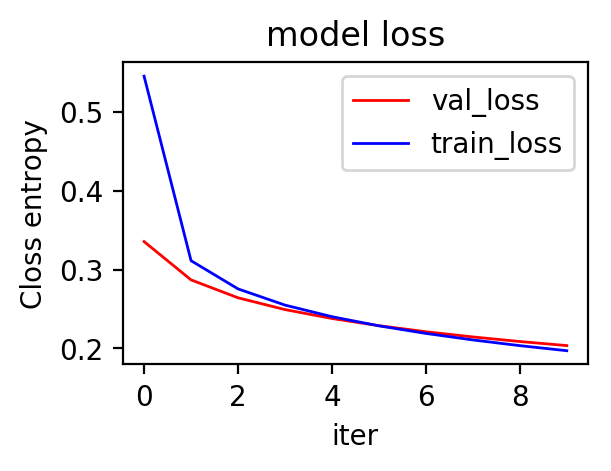

In [53]:
Neural_1.loss_graph()

In [54]:
Neural_1.predict(X_val)

array([2, 8, 4, ..., 2, 8, 8])

### ReLU & Xavier のモデル 

In [59]:
Neural_2 = ScratchDeepNeuralNetrowkClassifier(activation='relu', solver='adagrad', initial='xavier', epoch=10)

Neural_2.fit(X_train, y_train, X_val, y_val)

epoch:1-train_loss:0.2359068769564732
epoch:1-val_loss: 0.15054921900336615
epoch:2-train_loss:0.12404671788201005
epoch:2-val_loss: 0.12182450359710426
epoch:3-train_loss:0.09501950574080756
epoch:3-val_loss: 0.10819443289077511
epoch:4-train_loss:0.07793764808327713
epoch:4-val_loss: 0.1000541944801464
epoch:5-train_loss:0.0661732542624931
epoch:5-val_loss: 0.09424548999155218
epoch:6-train_loss:0.05746693686167582
epoch:6-val_loss: 0.08991766393311448
epoch:7-train_loss:0.050707865484375836
epoch:7-val_loss: 0.08675669117920617
epoch:8-train_loss:0.04524255086799771
epoch:8-val_loss: 0.08433699257275465
epoch:9-train_loss:0.04069327825027283
epoch:9-val_loss: 0.08249566880776854
epoch:10-train_loss:0.03684503363521667
epoch:10-val_loss: 0.08106960429291149


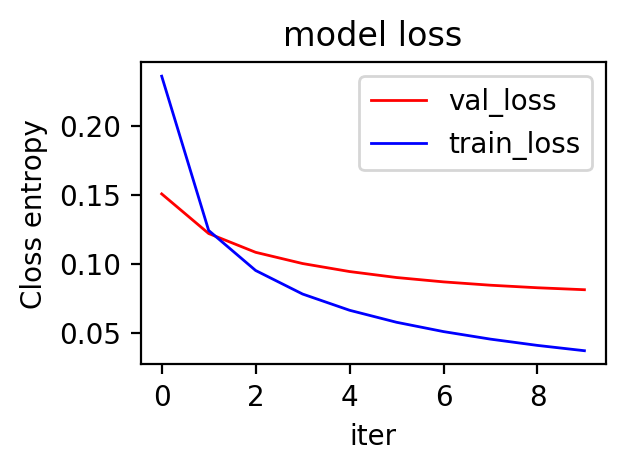

In [60]:
Neural_2.loss_graph()

### ハイパポリックタンジェント　＆　Xavier　のモデル

In [61]:
Neural_3 = ScratchDeepNeuralNetrowkClassifier(activation='tanh', solver='adagrad', initial='xavier', epoch=10)

Neural_3.fit(X_train, y_train, X_val, y_val)

epoch:1-train_loss:0.2861924333188542
epoch:1-val_loss: 0.21412267837942012
epoch:2-train_loss:0.18959184544169996
epoch:2-val_loss: 0.1818815048427623
epoch:3-train_loss:0.15989734658631793
epoch:3-val_loss: 0.16387926045949608
epoch:4-train_loss:0.14121334665112883
epoch:4-val_loss: 0.15195273843385665
epoch:5-train_loss:0.12770353803357432
epoch:5-val_loss: 0.14322938709328406
epoch:6-train_loss:0.1172125722987884
epoch:6-val_loss: 0.1364240525646525
epoch:7-train_loss:0.1086920941090965
epoch:7-val_loss: 0.13087736371230585
epoch:8-train_loss:0.10155343298937214
epoch:8-val_loss: 0.12621985905152788
epoch:9-train_loss:0.0954344905632145
epoch:9-val_loss: 0.12222846574739248
epoch:10-train_loss:0.09009797452544746
epoch:10-val_loss: 0.11875712853203221


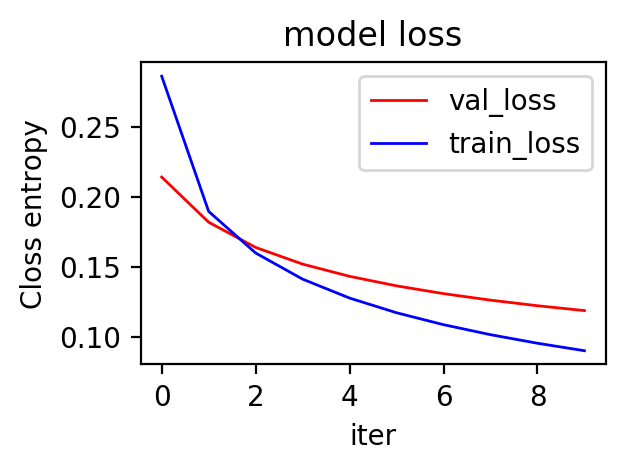

In [62]:
Neural_3.loss_graph()

### シグモイド　＆　He　のモデル

In [63]:
Neural_4 = ScratchDeepNeuralNetrowkClassifier(activation='sigmoid', solver='adagrad', initial='he', epoch=10)

Neural_4.fit(X_train, y_train, X_val, y_val)

epoch:1-train_loss:0.484587974486016
epoch:1-val_loss: 0.32229064727753337
epoch:2-train_loss:0.30207712289982436
epoch:2-val_loss: 0.2812225733605788
epoch:3-train_loss:0.270708612195356
epoch:3-val_loss: 0.26081819808428486
epoch:4-train_loss:0.2519301270396133
epoch:4-val_loss: 0.24701588805104435
epoch:5-train_loss:0.23816621239021663
epoch:5-val_loss: 0.23643895388697767
epoch:6-train_loss:0.2271465374047591
epoch:6-val_loss: 0.22779431819006973
epoch:7-train_loss:0.2178928706728569
epoch:7-val_loss: 0.2204591040553812
epoch:8-train_loss:0.20989095743360014
epoch:8-val_loss: 0.21408421772669717
epoch:9-train_loss:0.2028325943916282
epoch:9-val_loss: 0.20845072270578427
epoch:10-train_loss:0.1965153648630951
epoch:10-val_loss: 0.20340938118543828


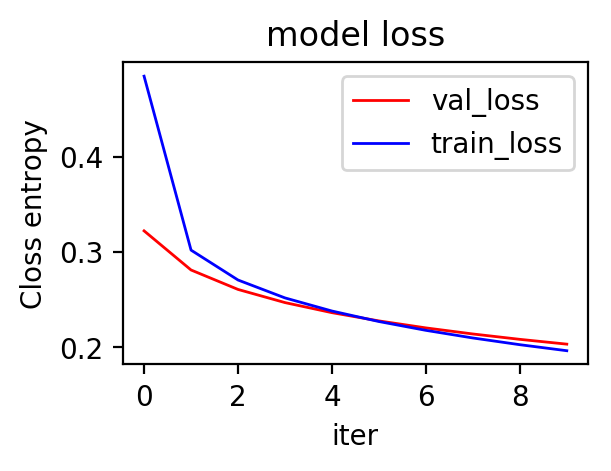

In [64]:
Neural_4.loss_graph()

### ReLU　＆　He　のモデル

In [66]:
Neural_5 = ScratchDeepNeuralNetrowkClassifier(activation='relu', solver='adagrad', initial='he', epoch=10)

Neural_5.fit(X_train, y_train, X_val, y_val)

epoch:1-train_loss:0.22201091726692085
epoch:1-val_loss: 0.1407107405084023
epoch:2-train_loss:0.1143774709403678
epoch:2-val_loss: 0.1148633510973273
epoch:3-train_loss:0.08691179183797078
epoch:3-val_loss: 0.10284662558878435
epoch:4-train_loss:0.0708128870765043
epoch:4-val_loss: 0.09561002120941993
epoch:5-train_loss:0.059725603528759566
epoch:5-val_loss: 0.09044007150851475
epoch:6-train_loss:0.051517462152489424
epoch:6-val_loss: 0.08676517941688931
epoch:7-train_loss:0.04508413257292083
epoch:7-val_loss: 0.08412824436272565
epoch:8-train_loss:0.03986788315659508
epoch:8-val_loss: 0.08211555418469671
epoch:9-train_loss:0.035545423384282
epoch:9-val_loss: 0.08057032631851323
epoch:10-train_loss:0.03190386220161792
epoch:10-val_loss: 0.07931744056060526


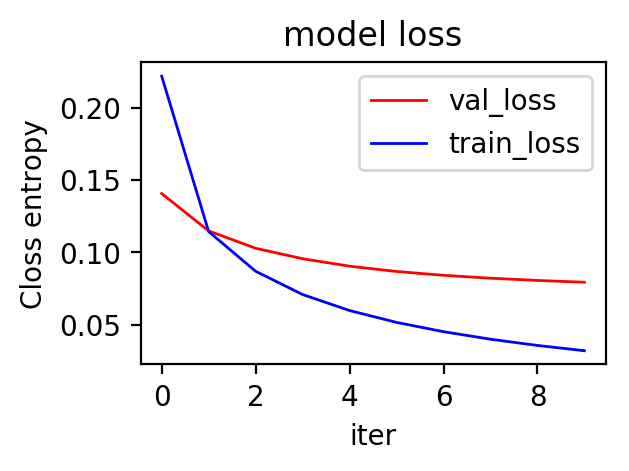

In [67]:
Neural_5.loss_graph()

### ハイパボリックタンジェント　＆　He　のモデル

In [69]:
Neural_6 = ScratchDeepNeuralNetrowkClassifier(activation='tanh', solver='adagrad', initial='he', epoch=10)

Neural_6.fit(X_train, y_train, X_val, y_val)

epoch:1-train_loss:0.26180165825608265
epoch:1-val_loss: 0.18532337614522845
epoch:2-train_loss:0.16134106298122486
epoch:2-val_loss: 0.15577759984573605
epoch:3-train_loss:0.1339971197158779
epoch:3-val_loss: 0.14019280811103296
epoch:4-train_loss:0.11724997749829585
epoch:4-val_loss: 0.13006686181921834
epoch:5-train_loss:0.10526057016966202
epoch:5-val_loss: 0.12275340014536217
epoch:6-train_loss:0.09599457834975803
epoch:6-val_loss: 0.1171306275587557
epoch:7-train_loss:0.08849617577081635
epoch:7-val_loss: 0.11262657718384911
epoch:8-train_loss:0.08223568220242469
epoch:8-val_loss: 0.10891057613189585
epoch:9-train_loss:0.07688783472770955
epoch:9-val_loss: 0.1057751467744278
epoch:10-train_loss:0.07223857349615732
epoch:10-val_loss: 0.10308257600242404


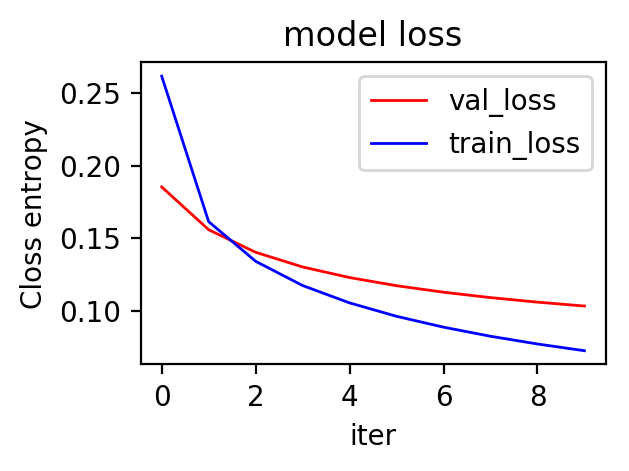

In [70]:
Neural_6.loss_graph()

重みの初期化方法は活性化関数との相性によって決定する。

* シグモイド関数/ハイパボリックタンジェント関数→Xavier
* ReLU関数→He

特に深いネットワークにおいては、初期の重み設定の方法を検討しないと学習の効率に大きな差が出る。